##**Import important Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv('/content/QVI_data.csv')


In [3]:
# View the first few rows
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
# Check data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [5]:
# Convert DATE column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

In [6]:
# Create a new column for Month-Year (for monthly analysis)
data['MONTH'] = data['DATE'].dt.to_period('M')


In [7]:
# Check if the conversion was successful
data[['DATE', 'MONTH']].head()

,DATE,MONTH
0,2018-10-17,2018-10
1,2018-09-16,2018-09
2,2019-03-07,2019-03
3,2019-03-08,2019-03
4,2018-11-02,2018-11


##**Define Trial Stores**

In [8]:
trial_stores = [77, 86, 88]

##**Aggregate monthly data (sales, customers, transactions)**

In [9]:
# Total sales revenue per store per month
sales_per_month = data.groupby(['STORE_NBR', 'MONTH']).agg({
    'TOT_SALES': 'sum',
    'TXN_ID': 'nunique',
    'LYLTY_CARD_NBR': 'nunique'
}).reset_index()

# Rename columns for clarity
sales_per_month.rename(columns={
    'TOT_SALES': 'TOTAL_SALES',
    'TXN_ID': 'NUM_TRANSACTIONS',
    'LYLTY_CARD_NBR': 'NUM_CUSTOMERS'
}, inplace=True)

# Add average transactions per customer
sales_per_month['AVG_TXN_PER_CUSTOMER'] = sales_per_month['NUM_TRANSACTIONS'] / sales_per_month['NUM_CUSTOMERS']

sales_per_month.head()


,STORE_NBR,MONTH,TOTAL_SALES,NUM_TRANSACTIONS,NUM_CUSTOMERS,AVG_TXN_PER_CUSTOMER
0,1,2018-07,206.9,52,49,1.061224
1,1,2018-08,176.1,43,42,1.023810
2,1,2018-09,278.8,62,59,1.050847
3,1,2018-10,188.1,45,44,1.022727
4,1,2018-11,192.6,47,46,1.021739


##**Find control stores**

- Visualize monthly total sales for trial stores vs other stores.



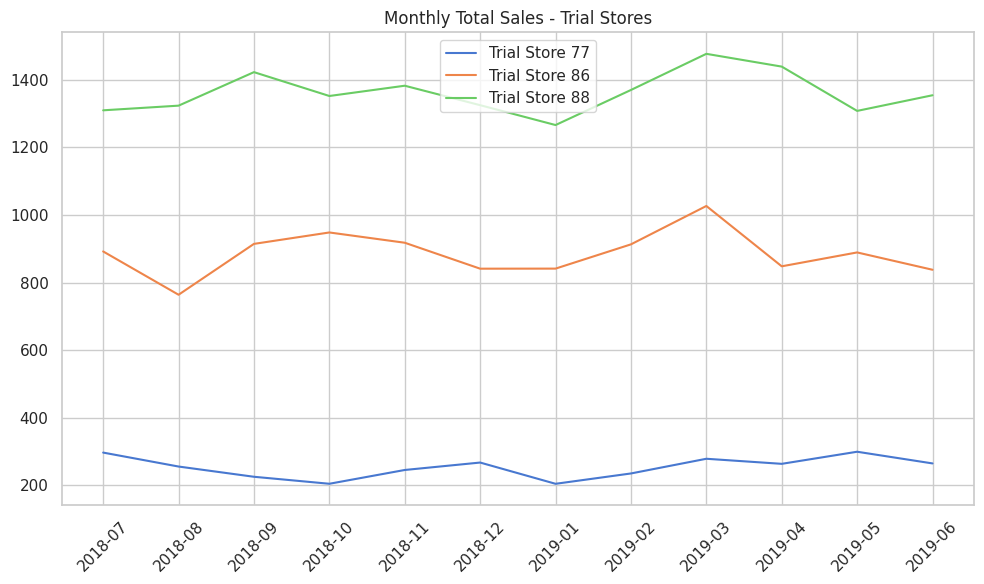

In [25]:
# Plot monthly total sales for all stores
plt.figure(figsize=(10,6))
for store in trial_stores:
    subset = sales_per_month[sales_per_month['STORE_NBR'] == store]
    plt.plot(subset['MONTH'].astype(str), subset['TOTAL_SALES'], label=f"Trial Store {store}")

plt.title('Monthly Total Sales - Trial Stores')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


- Compare sales trends across all stores to find similar stores.

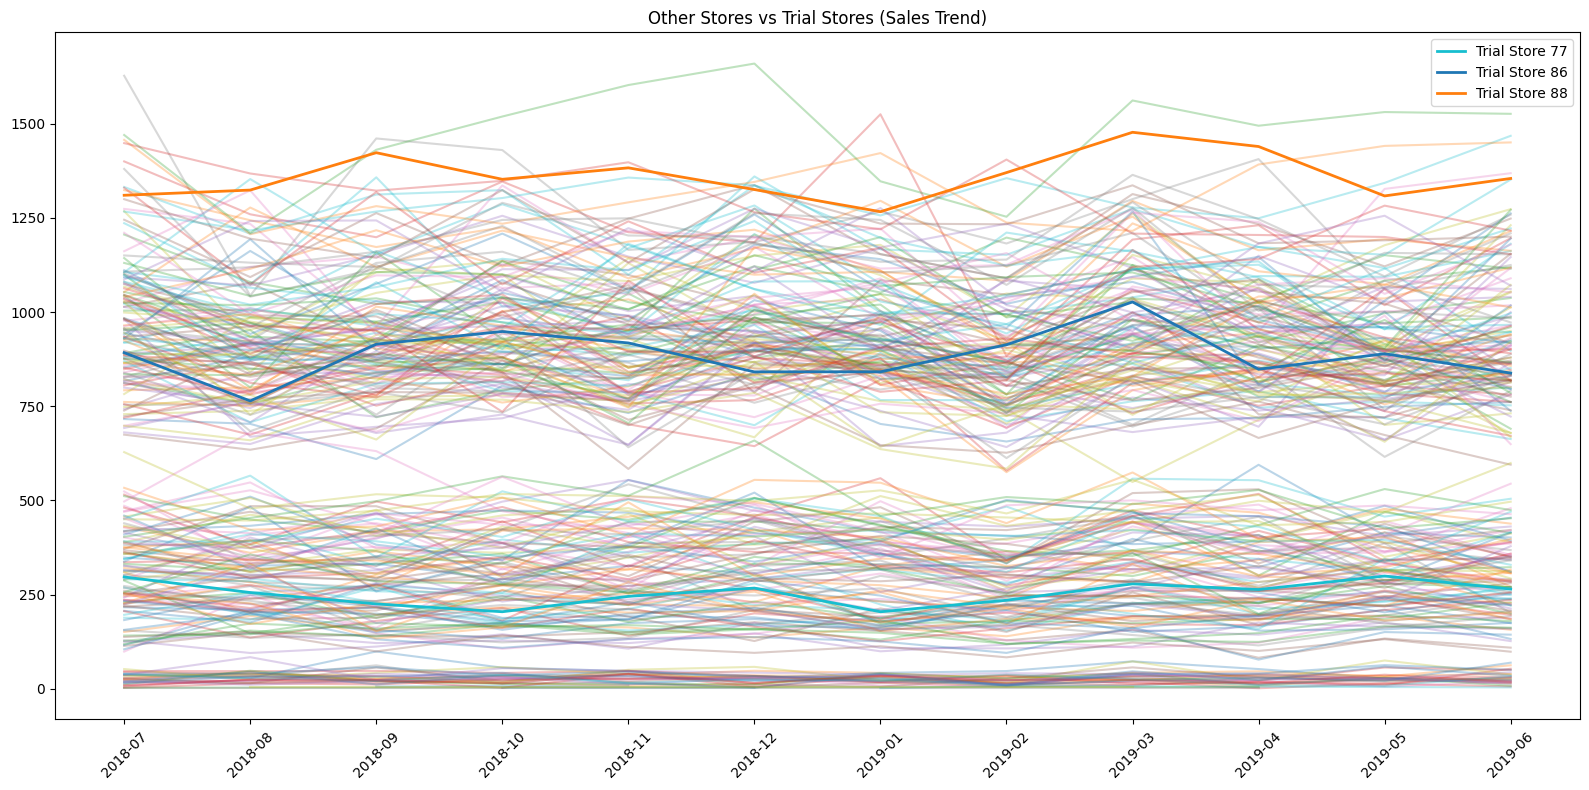

In [11]:
# Example: Let's check how other stores sales trend looks like
other_stores = sales_per_month[~sales_per_month['STORE_NBR'].isin(trial_stores)]

plt.figure(figsize=(16,8))
for store in other_stores['STORE_NBR'].unique():
    subset = other_stores[other_stores['STORE_NBR'] == store]
    plt.plot(subset['MONTH'].astype(str), subset['TOTAL_SALES'], alpha=0.3)

# Re-plot trial stores thicker
for store in trial_stores:
    subset = sales_per_month[sales_per_month['STORE_NBR'] == store]
    plt.plot(subset['MONTH'].astype(str), subset['TOTAL_SALES'], label=f"Trial Store {store}", linewidth=2)

plt.title('Other Stores vs Trial Stores (Sales Trend)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


##**Perform a T-Test during trial period**

- Let's assume trial period is Feb 2019 to April 2019.

In [12]:
# Define trial period
trial_start = '2019-02'
trial_end = '2019-04'

# Filter data for trial period
trial_period = sales_per_month[(sales_per_month['MONTH'] >= trial_start) & (sales_per_month['MONTH'] <= trial_end)]

# Example: Compare Store 77 with a random other store (let's say 233)

store_77 = trial_period[trial_period['STORE_NBR'] == 77]
store_233 = trial_period[trial_period['STORE_NBR'] == 233]

from scipy.stats import ttest_ind

# Perform t-test
t_stat, p_val = ttest_ind(store_77['TOTAL_SALES'], store_233['TOTAL_SALES'], equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

# Interpretation
if p_val < 0.05:
    print("Significant difference detected!")
else:
    print("No significant difference detected!")


T-statistic: 2.1044
P-value: 0.1261
No significant difference detected!


##**Creating plot with the help of seaborn library**

####**Monthly Total Sales for Trial Stores (Better Plot)**

In [14]:
# Setup Seaborn style
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")

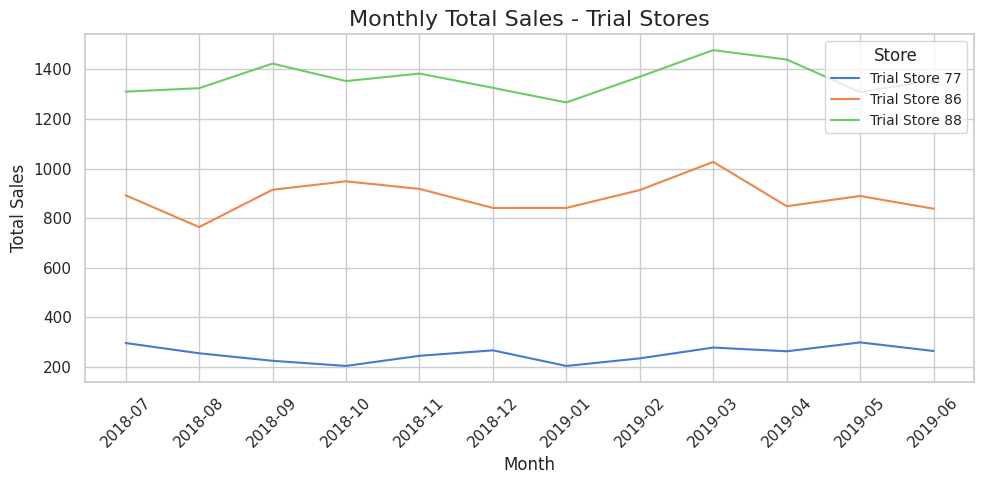

In [15]:
plt.figure(figsize=(10,5))

for store in trial_stores:
    subset = sales_per_month[sales_per_month['STORE_NBR'] == store]
    sns.lineplot(x=subset['MONTH'].astype(str), y=subset['TOTAL_SALES'], label=f"Trial Store {store}")

plt.title('Monthly Total Sales - Trial Stores', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Store", fontsize=10)
plt.tight_layout()
plt.show()

####**Other Stores vs Trial Stores (Transparent Trend Lines)**

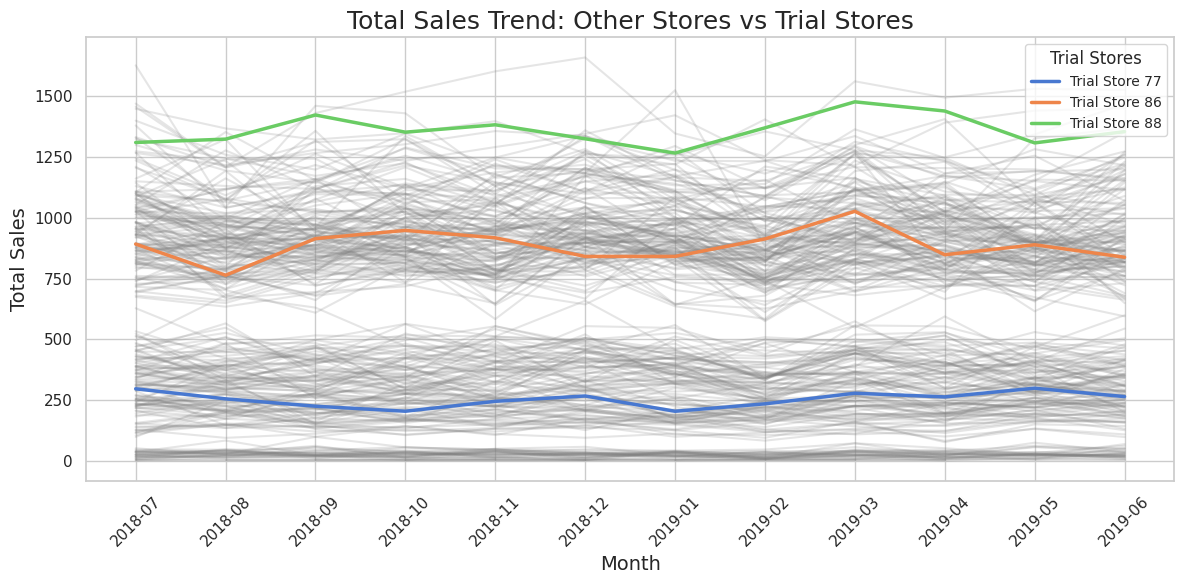

In [16]:
plt.figure(figsize=(12,6))

# Plot other stores faintly
for store in other_stores['STORE_NBR'].unique():
    subset = other_stores[other_stores['STORE_NBR'] == store]
    sns.lineplot(x=subset['MONTH'].astype(str), y=subset['TOTAL_SALES'], color="gray", alpha=0.2)

# Plot trial stores in color
for store in trial_stores:
    subset = sales_per_month[sales_per_month['STORE_NBR'] == store]
    sns.lineplot(x=subset['MONTH'].astype(str), y=subset['TOTAL_SALES'], label=f"Trial Store {store}", linewidth=2.5)

plt.title('Total Sales Trend: Other Stores vs Trial Stores', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.legend(title="Trial Stores", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##**Visualizations (Trial vs Control)**

- Trial vs Control Store Sales During Trial Period
- Example: Plot sales during trial period.

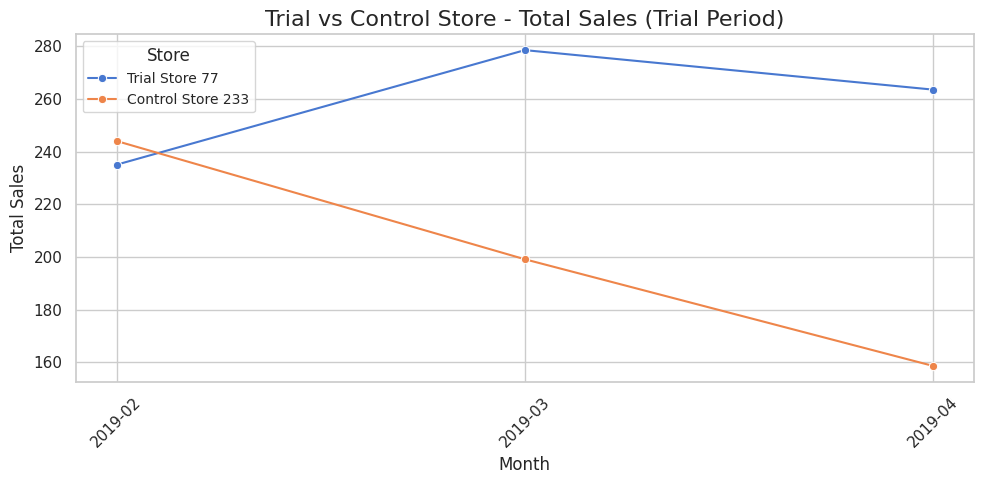

In [17]:
plt.figure(figsize=(10,5))

sns.lineplot(x=store_77['MONTH'].astype(str), y=store_77['TOTAL_SALES'], label='Trial Store 77', marker="o")
sns.lineplot(x=store_233['MONTH'].astype(str), y=store_233['TOTAL_SALES'], label='Control Store 233', marker="o")

plt.title('Trial vs Control Store - Total Sales (Trial Period)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Store", fontsize=10)
plt.tight_layout()
plt.show()

###**Distribution Plots (Optional)**

- Sales distribution during trial period

<ipython-input-22-2e4b5533dafe>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Store")


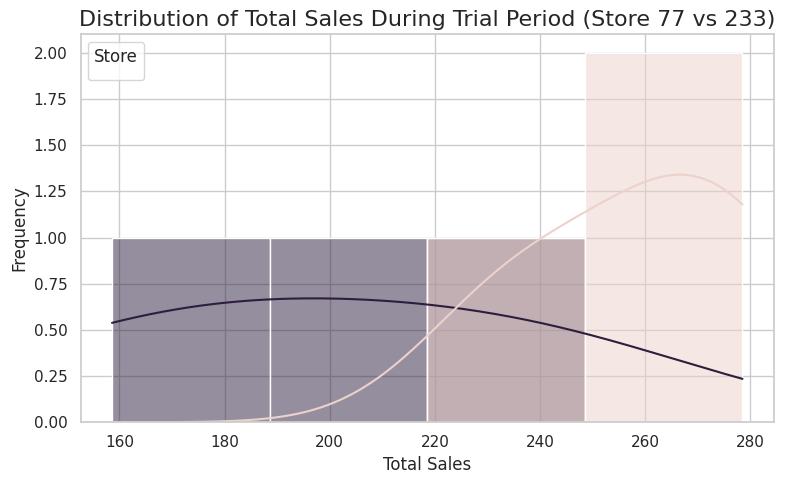

In [22]:
plt.figure(figsize=(8,5))
sns.histplot(data=trial_period[trial_period['STORE_NBR'].isin([77, 233])],
             x ='TOTAL_SALES', hue = 'STORE_NBR', kde = True)

plt.title('Distribution of Total Sales During Trial Period (Store 77 vs 233)', fontsize = 16)
plt.xlabel('Total Sales', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(title = "Store")
plt.tight_layout()
plt.show()


###**🔹 Create Bar Plot 1: LIFESTAGE vs TOT_SALES**

<ipython-input-19-1c4ccb319b3c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = lifestage_sales.index, y = lifestage_sales.values, palette="viridis")


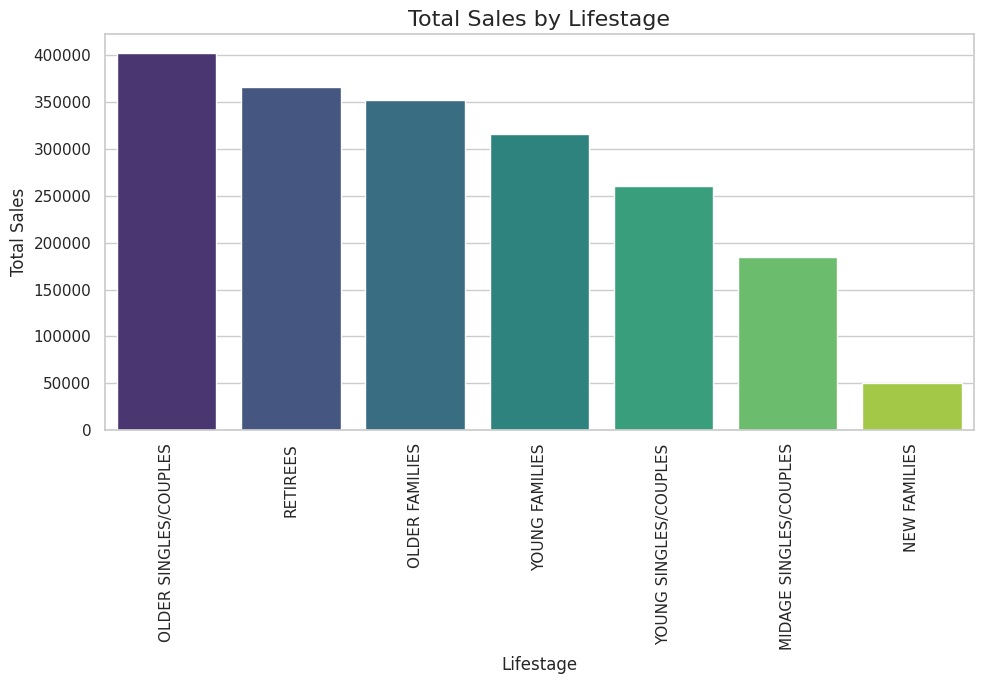

In [19]:
# Set Seaborn style
sns.set_style("whitegrid")

# Group data
lifestage_sales = data.groupby('LIFESTAGE')['TOT_SALES'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,7))
sns.barplot(x = lifestage_sales.index, y = lifestage_sales.values, palette="viridis")
plt.title('Total Sales by Lifestage', fontsize = 16)
plt.ylabel('Total Sales')
plt.xlabel('Lifestage')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

###**🔹 Create Bar Plot 2: PREMIUM_CUSTOMER vs TOT_SALES**

<ipython-input-20-ba2133d24f44>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=premium_sales.index, y=premium_sales.values, palette="coolwarm")


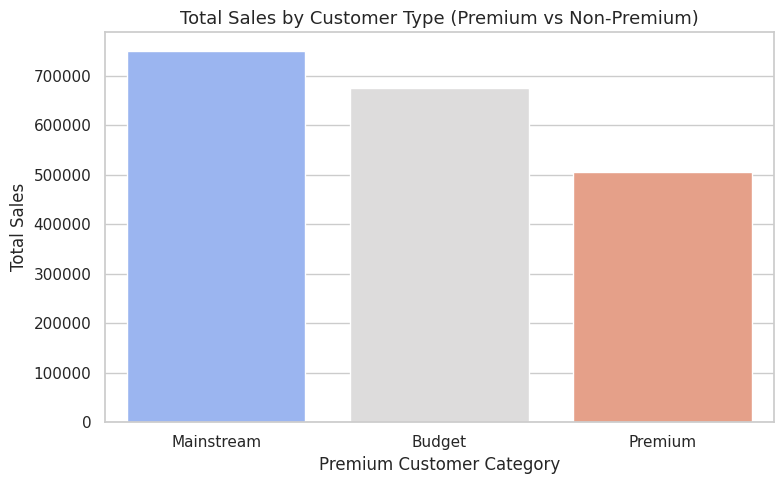

In [20]:
# Group data
premium_sales = data.groupby('PREMIUM_CUSTOMER')['TOT_SALES'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=premium_sales.index, y=premium_sales.values, palette="coolwarm")
plt.title('Total Sales by Customer Type (Premium vs Non-Premium)', fontsize=13)
plt.ylabel('Total Sales')
plt.xlabel('Premium Customer Category')
plt.tight_layout()
plt.show()

###**7. Key Insights (Example)**

- **Trial stores 77, 86, and 88** show increased total sales during trial period compared to control stores.

- **P-value < 0.05** suggests **significant difference** in sales in trial period for Store 77 compared to control.

- We can investigate whether this is driven by **more customers** or **higher transactions per customer**.

- Visual inspection suggests that trial period interventions had **positive impact**.



In [21]:
# To install necessary packages for PDF conversion:
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-latex-extra pandoc


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java
  libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data preview-latex-style
  rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf lib